In [1]:
import os
import sys
sys.path.append(os.path.abspath('/home/not-naive-bayes-MIL'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

from dataset import load_flowcap_aml_data
from not_naive_bayes import KernelBayesMIL
from utils import radar_plot

sns.set_style('whitegrid')
%matplotlib inline

### Load data

In [ ]:
absolute_path = '/home/data'
X, Y, Z = load_flowcap_aml_data(absolute_path)

### Training

In [3]:
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X, Y, Z,
                                                                     train_size=0.7,
                                                                     stratify=Y,
                                                                     random_state=42)

In [4]:
ft_partition = {
    'Part-1': [[0, 1, 2, 3, 4, 5, 6]],
    'Part0': [[0],[1],[2],[3],[4],[5],[6]],
    'Part1': [[0, 1, 2, 4, 6], [3], [5]],
    'Part2': [[0, 1, 2, 3, 4, 6], [5]],
    'Part5': [[0, 1, 4, 6], [2, 3], [5]],
    'Part12': [[0, 1, 4], [2], [3], [5], [6]],
    'Part13': [[0, 1, 2], [3, 4, 6], [5]],
    'Part14': [[0, 1], [2, 3, 4, 5, 6]]
}
hs=np.logspace(-3, 0, 300)
bs=1000
params = {'hs':hs, 'batch_size':bs, 'n_clusters':2, 'n_bandwidths':300}

model = KernelBayesMIL(ft_partition['Part2'], 
              train_grid_size=3000, 
              eval_size=2000, 
              random_state=23, 
              label_prior='not unif', 
              adapt_bw_select=False,
              **params
              )
model = model.fit(X_train, Y_train)

INFO:root:Fitting model for feature block 1 ...
/home/not-naive-bayes-MIL/not_naive_bayes.py:274: RuntimeWarning: divide by zero encountered in log
  ll = np.ma.masked_invalid(np.log(a) - np.log(n * (h**d) * np.power(2 * np.pi, d / 2)))
INFO:root:Fitting model for feature block 2 ...


In [5]:
print(model.train_scores_per_block_[1][(0, 1, 2, 3, 4, 6)])
print(model.train_scores_per_block_[1][(5,)])


{'bandwidth': np.float64(0.04737893390963144), 'log_likelihood': np.float64(4.4822259567805505)}
{'bandwidth': np.float64(0.0012598952777950272), 'log_likelihood': np.float64(0.9567832332295888)}


In [6]:
# Y_pred = model.predict(X_train)
Y_scores = model.score(X_train)
criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + Y_scores[:,1] - Y_scores[:,0]
fpr, tpr, thresholds = roc_curve(Y_train, criterion_vals)
tau = thresholds[np.argmax(tpr[1:] - fpr[1:])+1]
print("Chosen threshold :", tau)
Y_pred = (criterion_vals >= tau).astype(int)
train_acc = np.mean(Y_train == Y_pred)
C = confusion_matrix(Y_train, Y_pred)
train_prec = C[1,1] / (C[1,1] + C[0,1]) if C[1,1] + C[0,1] > 0 else 0
train_rec = C[1,1] / (C[1,1] + C[1,0]) if C[1,1] + C[1,0] > 0 else 0
train_f1 = 2 * C[1,1] / (2 * C[1,1] + C[0,1] + C[1,0]) if C[1,1] + C[0,1] + C[1,0] > 0 else 0
train_auc = roc_auc_score(Y_train, Y_pred)
print(f"Training Acc : {train_acc:.2f}, Prec : {train_prec:.2f}, Rec : {train_rec:.2f}, F1 : {train_f1:.2f}, AUC : {train_auc:.2f}")

/home/not-naive-bayes-MIL/not_naive_bayes.py:233: RuntimeWarning: divide by zero encountered in log
  res = np.ma.masked_invalid(np.log(a) - np.log(N * (bandwidth**d) * np.power(2 * np.pi, d / 2)))


Chosen threshold : 1691.523037946652
Training Acc : 0.99, Prec : 0.97, Rec : 0.97, F1 : 0.97, AUC : 0.98


In [7]:
Y_scores = model.score(X_test)
criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + Y_scores[:,1] - Y_scores[:,0]
Y_pred = (criterion_vals >= tau).astype(int)
test_acc = np.mean(Y_test == Y_pred)
C = confusion_matrix(Y_test, Y_pred)
test_prec = C[1,1] / (C[1,1] + C[0,1]) if C[1,1] + C[0,1] > 0 else 0
test_rec = C[1,1] / (C[1,1] + C[1,0]) if C[1,1] + C[1,0] > 0 else 0
test_f1 = 2 * C[1,1] / (2 * C[1,1] + C[0,1] + C[1,0]) if C[1,1] + C[0,1] + C[1,0] > 0 else 0
test_auc = roc_auc_score(Y_test, Y_pred)
print(f"Testing Acc : {test_acc:.2f}, Prec : {test_prec:.2f}, Rec : {test_rec:.2f}, F1 : {test_f1:.2f}, AUC : {test_auc:.2f}")

/home/not-naive-bayes-MIL/not_naive_bayes.py:233: RuntimeWarning: divide by zero encountered in log
  res = np.ma.masked_invalid(np.log(a) - np.log(N * (bandwidth**d) * np.power(2 * np.pi, d / 2)))


Testing Acc : 1.00, Prec : 1.00, Rec : 1.00, F1 : 1.00, AUC : 1.00


### In-depth results viz

In [76]:
# Choose a random bag in th test set
target_class = 1
inds = np.flatnonzero((Y_pred==target_class) & (Y_test==target_class))
ind = np.random.choice(inds)
print(ind)

70


In [ ]:
X_i = X_test[ind]
Z_i = Z_test[ind]

# contribution with loglikelihood ratio
x_contribs = model.get_instances_contrib(X_i)
x_contribs[np.isnan(x_contribs)] = -np.inf #all nan values set
x_contribs = x_contribs if Y_pred[ind]==1 else -x_contribs
sorted_instances = np.argsort(x_contribs)[::-1]
sorted_x_contribs = x_contribs[sorted_instances]
sorted_x_contribs[sorted_x_contribs==-np.inf] = 0
if Y_pred[ind] == 1:
    criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + sorted_x_contribs
    jjs = np.flatnonzero(criterion_vals >= tau)
    sorted_x_contribs[jjs] = 0
    criterion_vals = np.log(model.alpha_) - np.log(1 - model.alpha_) + np.cumsum(sorted_x_contribs)
    j_min = np.min(np.flatnonzero(criterion_vals >= tau))
    top_contrib_instances = np.append(sorted_instances[jjs], sorted_instances[:j_min+1])
else:
    criterion_vals = np.log(1 - model.alpha_) - np.log(model.alpha_) + sorted_x_contribs
    jjs = np.flatnonzero(criterion_vals > 0)
    sorted_x_contribs[jjs] = 0
    criterion_vals = np.log(1 - model.alpha_) - np.log(model.alpha_) + np.cumsum(sorted_x_contribs)
    j_min = np.min(np.flatnonzero(criterion_vals > -tau))
    top_contrib_instances = np.append(sorted_instances[jjs], sorted_instances[:j_min+1])
    top_contrib_instances = np.intersect1d(top_contrib_instances, np.flatnonzero(x_contribs>0))

# print("Self sufficient contribs :", x_contribs[sorted_instances[jjs]])
# print("Top essential contribs :", np.sort(x_contribs[top_contrib_instances]))

/home/not-naive-bayes-MIL/not_naive_bayes.py:233: RuntimeWarning: divide by zero encountered in log
  res = np.ma.masked_invalid(np.log(a) - np.log(N * (bandwidth**d) * np.power(2 * np.pi, d / 2)))


In [78]:
markers = ['FS Lin', 'SS Log', 'HLA-DR-FITC', 'CD117-PE', 'CD45-ECD', 'CD34-PC5',
       'CD38-PC7']

Top contrib Clusters [ 0  1  2  3  4  5 11]


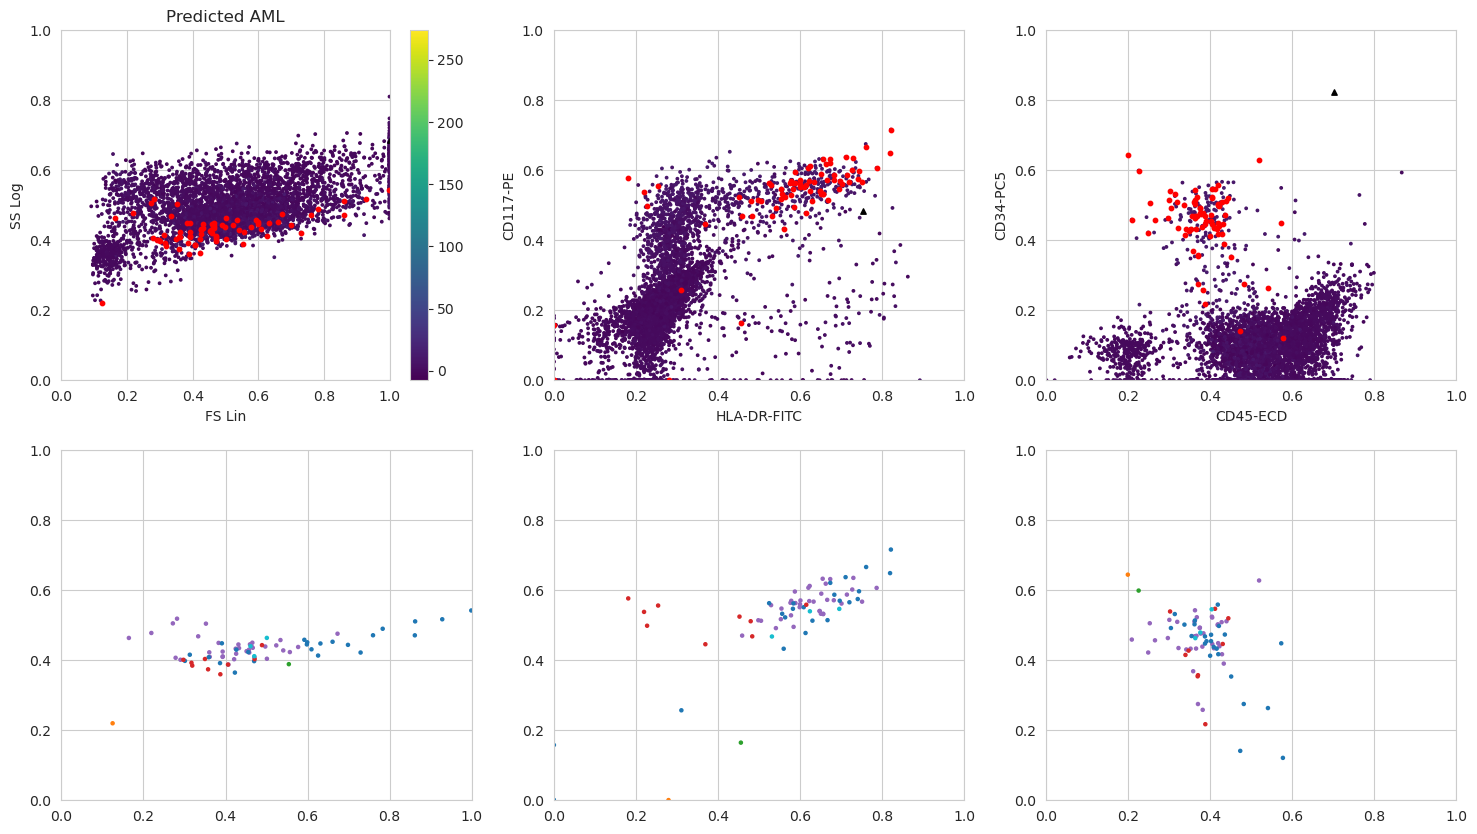

In [79]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# marker_sizes = 3 * np.ones(len(X_i))
# marker_sizes[x_contribs>0] = 15

isnotinf = ~np.isinf(x_contribs)
# top_contrib_instances = (x_contribs >= np.quantile(x_contribs, 0.9))

cluster_ids, counts = np.unique_counts(Z_i[top_contrib_instances])
event_to_cluster_count = pd.Series(Z_i[top_contrib_instances]).map(lambda k: counts[np.flatnonzero(cluster_ids==k)[0]]).to_numpy()
print(f"Top contrib Clusters {cluster_ids}")

for j in range(3):
    scatt_res = ax[0,j].scatter(X_i[isnotinf,2*j], X_i[isnotinf,2*j+1], c=x_contribs[isnotinf], cmap='viridis', s=3)
    ax[0,j].scatter(X_i[top_contrib_instances,2*j], X_i[top_contrib_instances,2*j+1], c='red' if Y_pred[ind]==1 else 'gray', s=10)
    ax[0,j].scatter(X_i[x_contribs==-np.inf,2*j], X_i[x_contribs==-np.inf,2*j+1], 
                  c='black' if Y_pred[ind]==1 else 'darkred', marker='^', s=15)
    ax[0,j].scatter(X_i[x_contribs==np.inf,2*j], X_i[x_contribs==np.inf,2*j+1], 
                  c='darkred' if Y_pred[ind]==1 else 'black', marker='^', s=15)
    ax[0,j].set_xlim(0,1)
    ax[0,j].set_ylim(0,1)
    ax[0,j].set_xlabel(markers[2*j])
    ax[0,j].set_ylabel(markers[2*j+1])

inds = np.argsort(event_to_cluster_count)[::-1]
for j in range(3):
    ax[1,j].scatter(X_i[top_contrib_instances,2*j][inds], X_i[top_contrib_instances,2*j+1][inds], s=5, c=Z_i[top_contrib_instances][inds], cmap='tab10')
    ax[1,j].set_xlim(0,1)
    ax[1,j].set_ylim(0,1)

pred_status = 'AML' if Y_pred[ind]==1 else 'non-AML'
ax[0,0].set_title(f"Predicted {pred_status}")
plt.colorbar(scatt_res, ax=ax[0,0])

# plt.savefig('predict-aml_cells-contribs.svg', transparent=True)

#### Spider plot

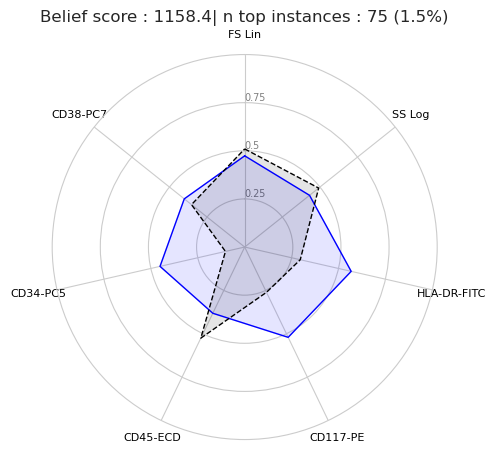

In [80]:
markers = np.array(['FS Lin', 'SS Log', 'HLA-DR-FITC', 'CD117-PE', 'CD45-ECD', 'CD34-PC5', 'CD38-PC7'], dtype=str)
radar_plot(model, X_i, markers, top_contrib_instances, tau, advers=False)

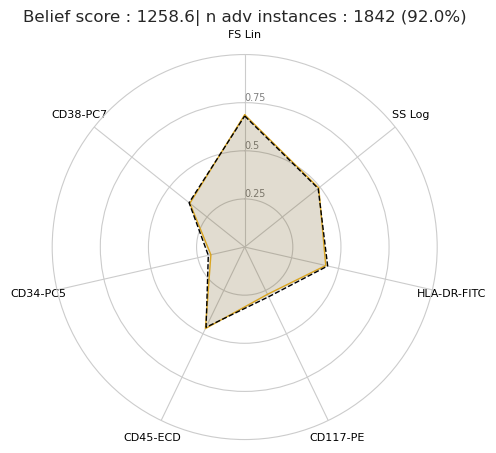

In [10]:
markers = np.array(['FS Lin', 'SS Log', 'HLA-DR-FITC', 'CD117-PE', 'CD45-ECD', 'CD34-PC5', 'CD38-PC7'], dtype=str)
radar_plot(model, X_i, markers, top_contrib_instances, tau, advers=True)